In [1]:
import re
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict

### Data Generation Function

This function `generate_production_logs` simulates a stream of production log data. It includes realistic patterns like temporal variations (different activities during business hours vs. night), sequential dependencies (e.g., login followed by file download), and a mechanism to inject subtle anomalies (e.g., unusually large file transfers or unexpected database exports during off-hours).

In [10]:
# Data generator - simulate production logs with realistic patterns
def generate_production_logs(num_records=10000):
    ips = [f"192.168.1.{i}" for i in range(10, 60)]
    logs = []
    current_time = datetime(2025, 12, 22, 0, 0, 0)  # start at midnight

    # state tracking for realistic sequences
    last_action = None
    user_sessions = {}  # track who's logged in

    i = 0
    while i < num_records:
        current_time += timedelta(seconds=random.randint(1, 10))
        ip = random.choice(ips)
        hour = current_time.hour

        # temporal patterns - different behavior by time of day
        is_business_hours = 9 <= hour <= 17
        is_night = 22 <= hour or hour <= 6

        # realistic sequence patterns
        if last_action == "LOGIN" and ip in user_sessions:
            # after login, users typically download files
            if random.random() < 0.7:
                action = "FILE_DOWNLOAD"
                # normal file sizes cluster around 200-400KB
                size = int(np.random.normal(300, 100))
                size = max(50, min(size, 800))  # clamp to reasonable range
                msg = f"File transfer initiated: {size}KB sent to {ip}"
            else:
                action = "WEB_GET"
                size = random.randint(5, 15)
                msg = f"HTTP GET /index.html from {ip} status=200"

        elif last_action == "DNS_QUERY":
            # DNS usually followed by web or file access
            if random.random() < 0.6:
                action = "WEB_GET"
                size = random.randint(5, 15)
                msg = f"HTTP GET /index.html from {ip} status=200"
            else:
                action = "FILE_DOWNLOAD"
                size = int(np.random.normal(300, 100))
                size = max(50, min(size, 800))
                msg = f"File transfer initiated: {size}KB sent to {ip}"

        elif is_night:
            # at night, mostly heartbeats and occasional logins
            if random.random() < 0.8:
                action, size, msg = "HEARTBEAT", 0, f"System health check: status=OK source_ip={ip}"
            else:
                action, size, msg = "LOGIN", 0, f"User authentication successful for {ip} via SSH"
                user_sessions[ip] = True

        elif is_business_hours:
            # during business hours, more varied activity
            choice = random.random()
            if choice < 0.15:
                action, size, msg = "HEARTBEAT", 0, f"System health check: status=OK source_ip={ip}"
            elif choice < 0.3:
                action, size, msg = "DNS_QUERY", 1, f"DNS resolution request for internal.service from {ip}"
            elif choice < 0.45:
                action, size, msg = "LOGIN", 0, f"User authentication successful for {ip} via SSH"
                user_sessions[ip] = True
            elif choice < 0.8:
                action = "FILE_DOWNLOAD"
                size = int(np.random.normal(300, 100))
                size = max(50, min(size, 800))
                msg = f"File transfer initiated: {size}KB sent to {ip}"
            else:
                action, size, msg = "WEB_GET", random.randint(5, 15), f"HTTP GET /index.html from {ip} status=200"

        else:
            # morning/evening - moderate activity
            choice = random.random()
            if choice < 0.4:
                action, size, msg = "HEARTBEAT", 0, f"System health check: status=OK source_ip={ip}"
            elif choice < 0.6:
                action, size, msg = "LOGIN", 0, f"User authentication successful for {ip} via SSH"
                user_sessions[ip] = True
            elif choice < 0.85:
                action = "FILE_DOWNLOAD"
                size = int(np.random.normal(300, 100))
                size = max(50, min(size, 800))
                msg = f"File transfer initiated: {size}KB sent to {ip}"
            else:
                action, size, msg = "DNS_QUERY", 1, f"DNS resolution request for internal.service from {ip}"

        # inject some anomalies, but not in first 1200 logs (training set)
        if i > 1200:
            # size anomaly - huge file download
            if random.random() < 0.0005:  # ~5 per 10k logs
                action, size = "FILE_DOWNLOAD", random.randint(2000000, 3000000)
                msg = f"File transfer initiated: {size}KB sent to {ip}"

            # temporal + sequence anomaly - DB_EXPORT at night (should never happen)
            if random.random() < 0.0003 and is_night:
                action, size = "DB_EXPORT", random.randint(5000, 10000)
                msg = f"CRITICAL: Database dump exported to external mirror for {ip}"

        logs.append({"index": i, "timestamp": current_time, "action": action, "message": msg, "size_kb": size})
        last_action = action
        i += 1

    return pd.DataFrame(logs)

### Bayesian Log Monitor Class

The `BayesianLogMonitor` class implements a Bayesian anomaly detection system for log data. It learns normal patterns in three key areas:

1.  **Sequence Transitions**: What log messages typically follow others.
2.  **Size Distributions**: The expected size (e.g., KB) for different action types (e.g., `FILE_DOWNLOAD`).
3.  **Temporal Patterns**: When certain actions are expected to occur throughout the day.

The model can be trained and then used to score new logs, identifying deviations from learned normal behavior across these dimensions. It also supports online updates to adapt to evolving log patterns.

In [11]:
class BayesianLogMonitor:
    def __init__(self, alpha=0.1):
        self.alpha = alpha  # smoothing factor
        self.template_to_id = {}
        self.id_to_template = {}
        self.action_to_id = {}
        self.prob_matrix = None
        self.mu = 0
        self.sigma = 0

        # per-action gaussian params
        self.mvn_means = {}
        self.mvn_covs = {}

        # time-based stuff
        self.hour_action_probs = None
        self.action_probs = None

    def _get_template(self, msg):
        # normalize log messages by replacing variable parts
        msg = re.sub(r"(\d{1,3}\.){3}\d{1,3}", "<IP>", msg)
        msg = re.sub(r"\d+KB", "<SIZE>", msg)
        msg = re.sub(r"\b\d+\b", "<NUM>", msg)
        return msg

    def train(self, df):
        df = df.copy()  # avoid pandas warnings

        print(f"Training on {len(df)} logs...")

        # learn log templates
        df['template'] = df['message'].apply(self._get_template)
        unique_t = df['template'].unique()
        self.template_to_id = {t: i for i, t in enumerate(unique_t)}
        self.id_to_template = {i: t for t, i in self.template_to_id.items()}
        num_templates = len(unique_t)
        print(f"Found {num_templates} unique templates")

        # build transition probabilities (what follows what)
        ids = df['template'].map(self.template_to_id).values
        transitions = np.zeros((num_templates, num_templates))
        for i in range(len(ids) - 1):
            transitions[ids[i], ids[i+1]] += 1

        # laplace smoothing to avoid zero probs
        self.prob_matrix = (transitions + self.alpha) / (transitions.sum(axis=1)[:, None] + self.alpha * num_templates)

        # store raw counts for incremental updates
        self.transition_counts = transitions
        self.total_observations = len(df)

        # learn size distributions per action type
        unique_actions = df['action'].unique()
        self.action_to_id = {a: i for i, a in enumerate(unique_actions)}

        # store running statistics for online updates
        self.action_stats = {}
        for action in unique_actions:
            action_data = df[df['action'] == action]['size_kb'].values
            if len(action_data) > 1:
                mean = np.mean(action_data)
                var = np.var(action_data) + 1e-6
                self.mvn_means[action] = np.array([mean])
                self.mvn_covs[action] = np.array([[var]])
                self.action_stats[action] = {
                    'count': len(action_data),
                    'sum': np.sum(action_data),
                    'sum_sq': np.sum(action_data ** 2)
                }
            else:
                self.mvn_means[action] = np.array([0])
                self.mvn_covs[action] = np.array([[100]])
                self.action_stats[action] = {'count': 1, 'sum': 0, 'sum_sq': 0}

        # temporal patterns - different actions happen at different times
        df['hour'] = df['timestamp'].dt.hour
        hour_action_counts = pd.crosstab(df['hour'], df['action'])
        hour_action_counts = hour_action_counts + self.alpha
        self.hour_action_probs = hour_action_counts.div(hour_action_counts.sum(axis=1), axis=0)

        # store raw counts for temporal updates
        self.hour_action_counts = hour_action_counts - self.alpha  # remove smoothing for storage

        action_counts = df['action'].value_counts()
        self.action_probs = (action_counts + self.alpha) / (len(df) + self.alpha * len(unique_actions))

        print("Training complete")

    def update_online(self, new_logs, decay=0.95):
        """
        Incrementally update model with new logs.
        decay: weight for old data (0.95 = keep 95% of old data weight)
        """
        new_logs = new_logs.copy()
        new_logs['template'] = new_logs['message'].apply(self._get_template)

        # handle new templates that weren't in training
        for template in new_logs['template'].unique():
            if template not in self.template_to_id:
                new_id = len(self.template_to_id)
                self.template_to_id[template] = new_id
                self.id_to_template[new_id] = template
                # expand transition matrix
                old_size = self.transition_counts.shape[0]
                new_size = old_size + 1
                new_transitions = np.zeros((new_size, new_size))
                new_transitions[:old_size, :old_size] = self.transition_counts
                self.transition_counts = new_transitions

        # update transition counts with decay
        self.transition_counts *= decay
        ids = new_logs['template'].map(self.template_to_id).values
        for i in range(len(ids) - 1):
            self.transition_counts[ids[i], ids[i+1]] += 1

        # recompute probabilities
        num_templates = self.transition_counts.shape[0]
        self.prob_matrix = (self.transition_counts + self.alpha) / \
                          (self.transition_counts.sum(axis=1)[:, None] + self.alpha * num_templates)

        # update action statistics with decay
        for action in new_logs['action'].unique():
            action_data = new_logs[new_logs['action'] == action]['size_kb'].values

            if action not in self.action_stats:
                # new action type
                self.action_stats[action] = {
                    'count': len(action_data),
                    'sum': np.sum(action_data),
                    'sum_sq': np.sum(action_data ** 2)
                }
            else:
                # apply decay to old stats, add new data
                stats = self.action_stats[action]
                stats['count'] = stats['count'] * decay + len(action_data)
                stats['sum'] = stats['sum'] * decay + np.sum(action_data)
                stats['sum_sq'] = stats['sum_sq'] * decay + np.sum(action_data ** 2)

            # recompute mean and variance from running stats
            stats = self.action_stats[action]
            if stats['count'] > 1:
                mean = stats['sum'] / stats['count']
                variance = (stats['sum_sq'] / stats['count']) - (mean ** 2)
                variance = max(variance, 1e-6)  # prevent negative due to numerical errors
                self.mvn_means[action] = np.array([mean])
                self.mvn_covs[action] = np.array([[variance]])

        # update temporal patterns with decay
        new_logs['hour'] = new_logs['timestamp'].dt.hour
        new_hour_counts = pd.crosstab(new_logs['hour'], new_logs['action'])

        # apply decay to old counts
        self.hour_action_counts *= decay

        # add new counts
        for hour in new_hour_counts.index:
            for action in new_hour_counts.columns:
                if hour not in self.hour_action_counts.index:
                    self.hour_action_counts.loc[hour] = 0
                if action not in self.hour_action_counts.columns:
                    self.hour_action_counts[action] = 0
                self.hour_action_counts.loc[hour, action] += new_hour_counts.loc[hour, action]

        # recompute probabilities
        smoothed = self.hour_action_counts + self.alpha
        self.hour_action_probs = smoothed.div(smoothed.sum(axis=1), axis=0)

        print(f"Model updated with {len(new_logs)} new logs (decay={decay})")

    def score_vectorized(self, df):
        # calculate anomaly scores for all logs
        df = df.copy()

        df['template'] = df['message'].apply(self._get_template)
        ids = np.array([self.template_to_id.get(t, -1) for t in df['template']])

        # sequence scoring - new, with vectors!
        s_seq = np.zeros(len(ids))
        prev_ids = ids[:-1]
        curr_ids = ids[1:]
        valid_mask = (prev_ids != -1) & (curr_ids != -1)

        probs = np.full(len(prev_ids), 1e-15)
        probs[valid_mask] = self.prob_matrix[prev_ids[valid_mask], curr_ids[valid_mask]]
        s_seq[1:] = -np.log(probs)

        # size-based scoring using per-action gaussians
        s_mvn = np.zeros(len(df))
        for action in self.mvn_means.keys():
            action_mask = (df['action'] == action).values
            if action_mask.sum() > 0:
                sizes = df.loc[action_mask, 'size_kb'].values.reshape(-1, 1)
                try:
                    mvn = multivariate_normal(mean=self.mvn_means[action],
                                             cov=self.mvn_covs[action])
                    pdf_vals = mvn.pdf(sizes)
                    s_mvn[action_mask] = -np.log(pdf_vals + 1e-15)
                except:
                    s_mvn[action_mask] = 0  # numerical issues, skip

        # time-of-day scoring
        df['hour'] = df['timestamp'].dt.hour
        s_temporal = np.zeros(len(df))
        # fix this at some point
        for idx, row in df.iterrows():
            hour = row['hour']
            action = row['action']

            if hour in self.hour_action_probs.index and action in self.hour_action_probs.columns:
                p_temporal = self.hour_action_probs.loc[hour, action]
            else:
                p_temporal = self.action_probs.get(action, 1e-6)

            s_temporal[idx] = -np.log(p_temporal + 1e-15)

        # normalize temporal to same scale as sequence
        s_temporal = s_temporal / (s_temporal.mean() + 1e-6) * s_seq.mean()

        # combine all three scores (TODO: tune these weights)
        return s_seq + 0.5 * s_mvn + 0.3 * s_temporal

### Main Execution: Data Generation, Training, and Scoring

This section orchestrates the anomaly detection process:

1.  **Generate Data**: Creates a synthetic dataset of log entries using `generate_production_logs`.
2.  **Initialize Monitor**: Instantiates the `BayesianLogMonitor`.
3.  **Train Model**: Trains the monitor on a sampled subset of the generated logs. This sampling helps ensure that the training data covers a representative distribution of hours.
4.  **Score All Logs**: Applies the trained monitor to score all generated logs, calculating a 'surprise score' for each.

In [17]:
print("Generating test data...")
df_main = generate_production_logs(10000)

monitor = BayesianLogMonitor(alpha=0.1)

# train on a representative sample across all hours, not just the first 1000
# this avoids temporal bias where training only sees nighttime logs
sample_indices = np.random.choice(len(df_main), size=min(2000, len(df_main)), replace=False)
sample_indices.sort()
training_data = df_main.iloc[sample_indices[:1000]]  # still use 1000, but sampled

print(f"Training hours represented: {sorted(training_data['timestamp'].dt.hour.unique())}")
monitor.train(training_data)

print("\nScoring all logs...")
df_main['surprise_score'] = monitor.score_vectorized(df_main)

Generating test data...
Training hours represented: [0, 1, 2, 3, 4, 5, 6, 7]
Training on 1000 logs...
Found 5 unique templates
Training complete

Scoring all logs...


### Anomaly Thresholds

After scoring, we calculate percentile-based thresholds (95th, 99th, 99.9th) to categorize anomalies. These thresholds help in defining different levels of alert severity (e.g., warning, alert, critical) based on the 'surprise score'.

In [18]:
# use percentiles instead of hard-coded thresholds
p95 = np.percentile(df_main['surprise_score'], 95)
p99 = np.percentile(df_main['surprise_score'], 98)
p999 = np.percentile(df_main['surprise_score'], 99.5)

print(f"\nThresholds:")
print(f"  95th percentile: {p95:.2f}")
print(f"  99th percentile: {p99:.2f}")
print(f"  99.9th percentile: {p999:.2f}")

threshold = p99


Thresholds:
  95th percentile: 6.27
  99th percentile: 6.61
  99.9th percentile: 7.10


### Visualization of Anomaly Scores

This section generates two plots:

1.  **Anomaly Score Timeline**: Displays the surprise score for each log entry over time, with horizontal lines indicating the calculated percentile thresholds. Anomalies falling into 'warning', 'alert', or 'critical' categories are highlighted with distinct markers and colors. The top 8 anomalies are annotated with their action and timestamp.
2.  **Score Distribution Histogram**: Shows the distribution of all surprise scores, with vertical lines marking the 95th, 99th, and 99.9th percentiles to illustrate where the thresholds fall within the overall score range.


Generating visualization...
Saved to enhanced_bayesian_analytics.png


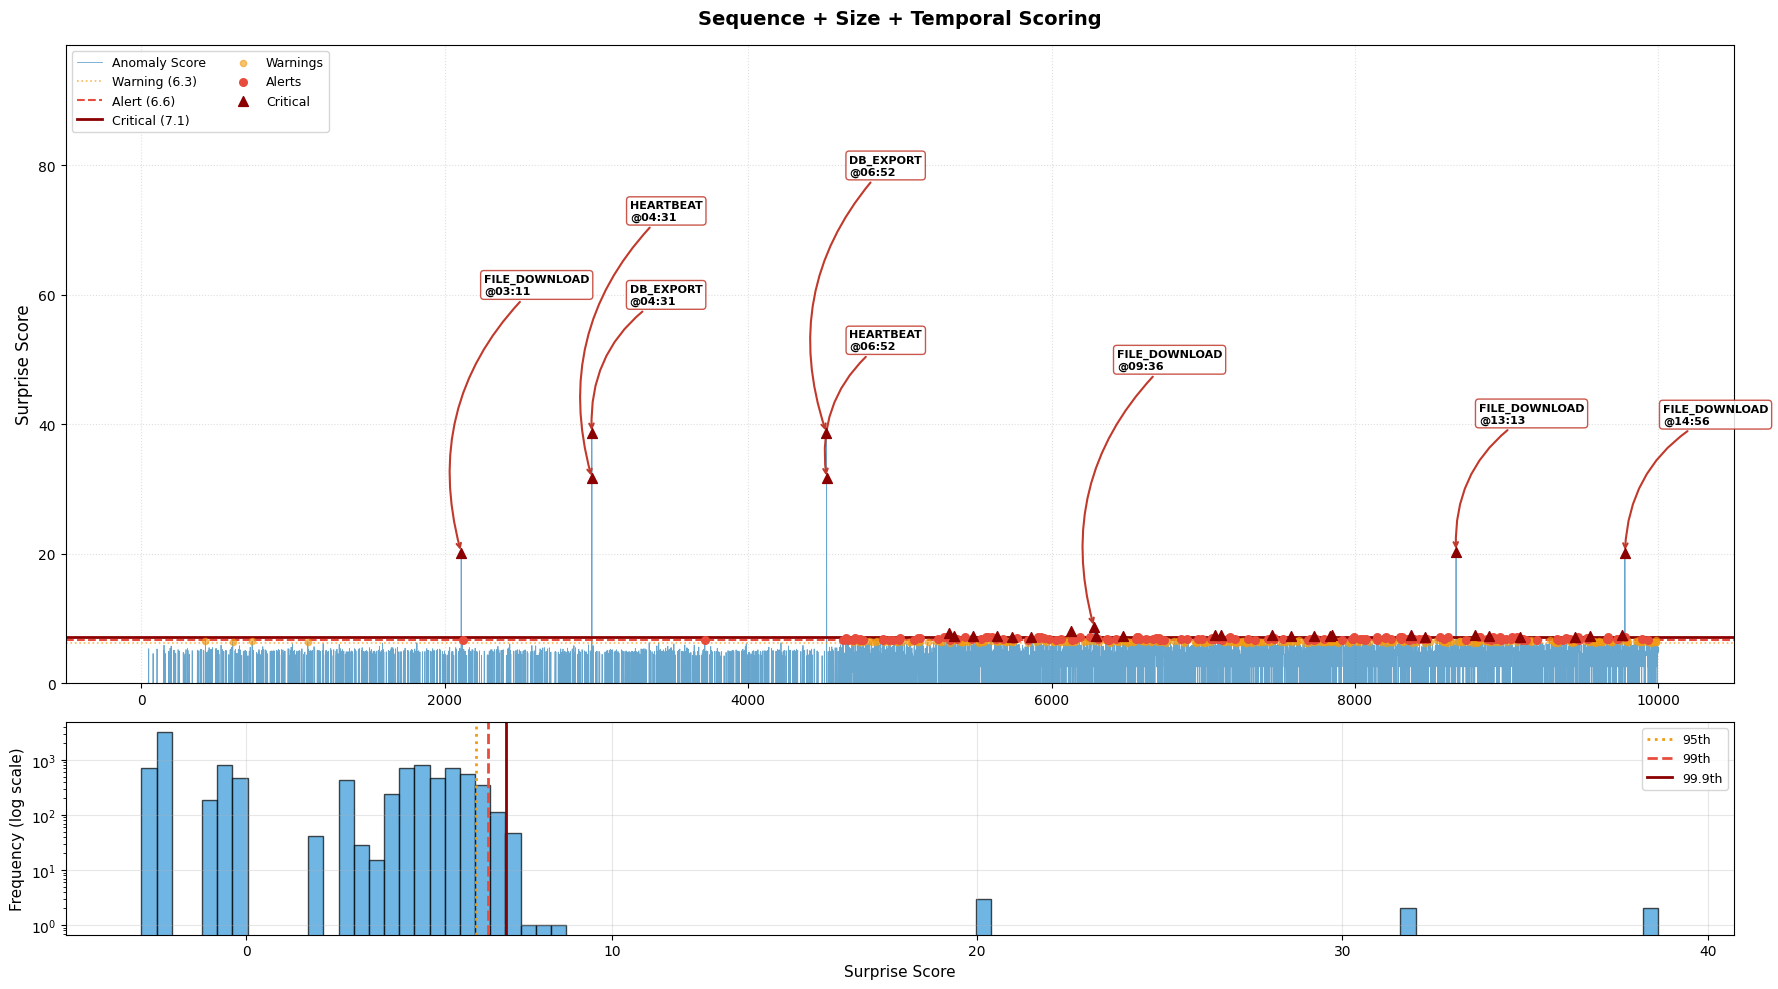

In [19]:
# plot results
print("\nGenerating visualization...")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), height_ratios=[3, 1])

# main timeline plot
ax1.plot(df_main['index'], df_main['surprise_score'],
             color='#2980b9', linewidth=0.6, alpha=0.7, label='Anomaly Score')

# threshold lines
ax1.axhline(y=p95, color='#f39c12', linestyle=':', linewidth=1.2,
                label=f'Warning ({p95:.1f})', alpha=0.7)
ax1.axhline(y=p99, color='#e74c3c', linestyle='--', linewidth=1.5,
                label=f'Alert ({p99:.1f})')
ax1.axhline(y=p999, color='#8b0000', linestyle='-', linewidth=2,
                label=f'Critical ({p999:.1f})')

# categorize anomalies
warnings = df_main[(df_main['surprise_score'] > p95) &
                       (df_main['surprise_score'] <= p99)]
alerts = df_main[(df_main['surprise_score'] > p99) &
                     (df_main['surprise_score'] <= p999)]
critical = df_main[df_main['surprise_score'] > p999]

ax1.scatter(warnings['index'], warnings['surprise_score'],
               color='#f39c12', s=20, zorder=4, alpha=0.6, label='Warnings')
ax1.scatter(alerts['index'], alerts['surprise_score'],
               color='#e74c3c', s=30, zorder=5, label='Alerts')
ax1.scatter(critical['index'], critical['surprise_score'],
               color='#8b0000', s=50, zorder=6, marker='^', label='Critical')

# annotate top anomalies
top_anomalies = df_main.nlargest(8, 'surprise_score')
for i, (idx, row) in enumerate(top_anomalies.iterrows()):
    y_offset = 20 if i % 2 == 0 else 40
    x_offset = 250 if i % 3 == 0 else 150

    ax1.annotate(
        f"{row['action']}\n@{row['timestamp'].strftime('%H:%M')}",
        xy=(idx, row['surprise_score']),
        xytext=(idx + x_offset, row['surprise_score'] + y_offset),
        fontsize=8,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#c0392b", alpha=0.85),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3", color='#c0392b', lw=1.5)
    )

ax1.set_title("Sequence + Size + Temporal Scoring",
                 fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel("Surprise Score", fontsize=12)
ax1.set_ylim(0, df_main['surprise_score'].max() + 60)
ax1.grid(True, which='both', linestyle=':', alpha=0.4)
ax1.legend(loc='upper left', fontsize=9, ncol=2)

# distribution histogram
ax2.hist(df_main['surprise_score'], bins=100, color='#3498db', alpha=0.7, edgecolor='black')
ax2.axvline(p95, color='#f39c12', linestyle=':', linewidth=2, label='95th')
ax2.axvline(p99, color='#e74c3c', linestyle='--', linewidth=2, label='99th')
ax2.axvline(p999, color='#8b0000', linestyle='-', linewidth=2, label='99.9th')
ax2.set_xlabel("Surprise Score", fontsize=11)
ax2.set_ylabel("Frequency (log scale)", fontsize=11)
ax2.set_yscale('log')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('enhanced_bayesian_analytics.png', dpi=150, bbox_inches='tight')
print("Saved to enhanced_bayesian_analytics.png")

plt.show()

### Summary of Anomaly Detection

This final section provides a quantitative summary of the anomaly detection results, including the total number of logs processed, the size of the training set, and the count of logs categorized into warnings, alerts, and critical anomalies. It also displays a table of the top 10 most anomalous log entries based on their surprise scores.

In [7]:
# print summary
print(f"\n{'='*60}")
print(f"RESULTS")
print(f"{'='*60}")
print(f"Total logs: {len(df_main)}")
print(f"Training size: {len(training_data)}")
print(f"\nDetections:")
print(f"  Warnings (95-99th): {len(warnings)}")
print(f"  Alerts (99-99.9th): {len(alerts)}")
print(f"  Critical (>99.9th): {len(critical)}")

print(f"\n{'='*60}")
print("TOP 10 ANOMALIES")
print(f"{'='*60}")
top_10 = df_main.nlargest(10, 'surprise_score')[['index', 'timestamp', 'action', 'size_kb', 'surprise_score']]
top_10['time'] = top_10['timestamp'].dt.strftime('%H:%M:%S')
print(top_10[['index', 'time', 'action', 'size_kb', 'surprise_score']].to_string(index=False))


RESULTS
Total logs: 10000
Training size: 1000

Detections:
  Warnings (95-99th): 400
  Alerts (99-99.9th): 90
  Critical (>99.9th): 10

TOP 10 ANOMALIES
 index     time        action  size_kb  surprise_score
  1458 02:14:07 FILE_DOWNLOAD  2694025       19.791482
  4974 07:37:56 FILE_DOWNLOAD  2826772       19.495042
  8557 13:06:02 FILE_DOWNLOAD  2797496       19.130535
  2022 03:05:44 FILE_DOWNLOAD  2467136       18.183251
  2682 04:05:57 FILE_DOWNLOAD  2419052       16.977298
  3431 05:13:25 FILE_DOWNLOAD  2260673       16.472236
  8606 13:10:32 FILE_DOWNLOAD  2331221       16.342477
  7643 11:41:42 FILE_DOWNLOAD       50        9.976717
  5486 08:23:44 FILE_DOWNLOAD       59        9.976715
  5728 08:46:01 FILE_DOWNLOAD       66        9.976714
